In [1]:
from typing import Tuple

import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score, precision_score, precision_recall_curve, confusion_matrix, roc_curve, roc_auc_score

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

df_filename = './data/apex-legends-steam-reviews.csv'

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/anatolii/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv(df_filename)

In [3]:
df['Recommended'].value_counts()

Recommended
True     9346
False    5344
Name: count, dtype: int64

In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df['Text'] = df['Text'].astype(str)
df['Recommended'] = df['Recommended'].apply(lambda x: not x).astype(int)
df = df.rename(columns={'Recommended': 'Not Recommended'})
df['Not Recommended'].value_counts()

Not Recommended
0    9346
1    5344
Name: count, dtype: int64

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier

In [6]:
X = df['Text']
y = df['Not Recommended']

In [7]:
y.value_counts()

Not Recommended
0    9346
1    5344
Name: count, dtype: int64

In [8]:
stop_words = set(stopwords.words('english'))


def tokenize(text: str):
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.lower()
    tokens = [t for t in text.split() if t not in stop_words]
    ps = PorterStemmer()
    tokens = [ps.stem(t) for t in tokens]
    return tokens

def precision_recall_score(y_test, y_pred, console_print: bool = True) -> Tuple[float, float]:
    precision = precision_score(y_test, y_pred, )
    recall = recall_score(y_test, y_pred)
    if console_print:
        print(f'Precision: {precision} \nRecall: {recall}')
    return precision, recall

def plot_confusion_matrix(conf_matrix, figsize: Tuple[float, float] = (8, 8)) -> None:
    plt.subplots(figsize=figsize)

    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Recommended', 'Not Recommended'],
                yticklabels=['Recommended', 'Not Recommended'])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def plot_precision_recall_curve(precision, recall) -> None:
    plt.subplots(figsize=(8,8))
    plt.plot(recall, precision, marker='.')
    plt.grid(True, color='grey', linestyle='--')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

vectorizer = TfidfVectorizer(tokenizer=tokenize, max_features=5000, token_pattern=None)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=37)

In [10]:
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

(Not Recommended
 0    0.632914
 1    0.367086
 Name: proportion, dtype: float64,
 Not Recommended
 0    0.649421
 1    0.350579
 Name: proportion, dtype: float64)

In [11]:
pipeline = Pipeline(steps=[
    ('vectorizer', vectorizer),
    ('model', XGBClassifier(random_state=37))
])

In [12]:
%%time
pipeline.fit(X_train, y_train)

CPU times: user 18 s, sys: 141 ms, total: 18.1 s
Wall time: 4.26 s


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_features=5000, token_pattern=None,
                                 tokenizer=<function tokenize at 0x7f3440899800>)),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               featu...ow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=37, ...))])

In [13]:
y_pred = pipeline.predict(X_test)

In [14]:
precision_recall_score(y_test, y_pred)

Precision: 0.7639751552795031 
Recall: 0.5970873786407767


(np.float64(0.7639751552795031), np.float64(0.5970873786407767))

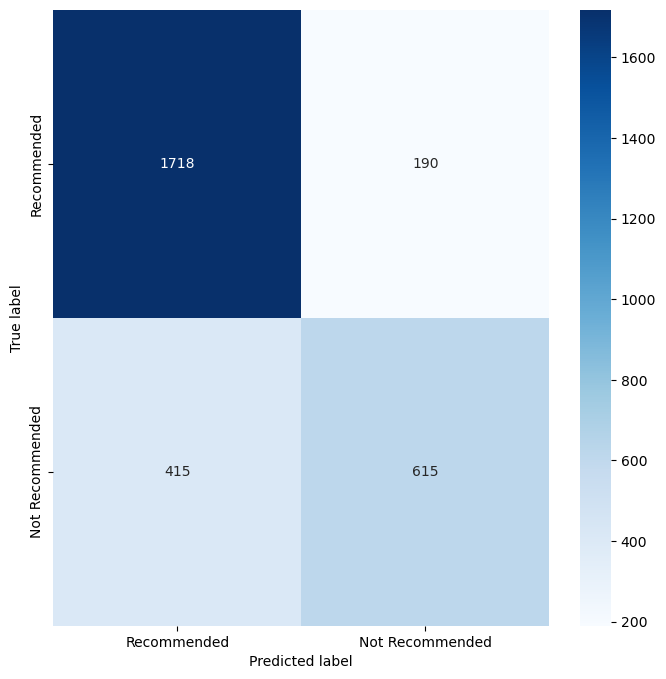

In [15]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

В неоптимизированном виде алгоритм справляется немного хуже, чем линейная регрессия.

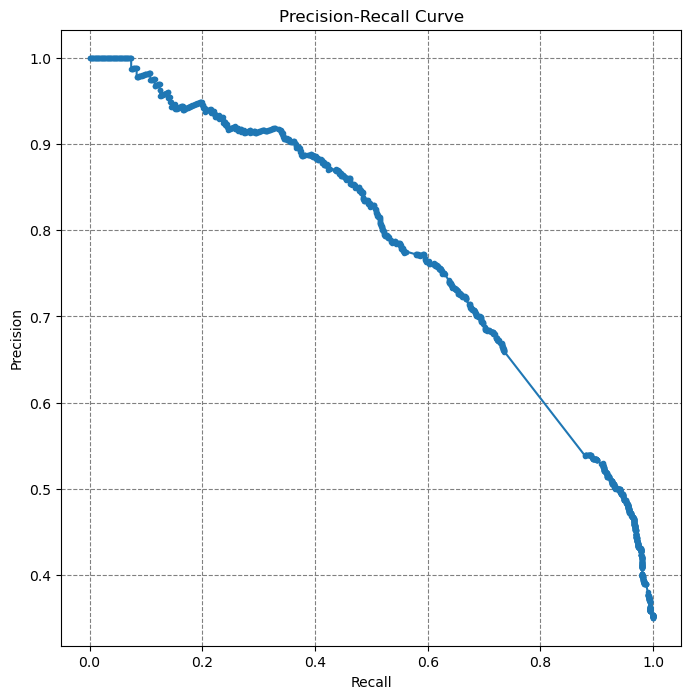

In [16]:
y_probas = pipeline.predict_proba(X_test)[:, 1]
precision_curve, recall_curve, thresholds_curve = precision_recall_curve(y_test, y_probas)
plot_precision_recall_curve(precision_curve, recall_curve)

In [17]:
grid_params = {
    'vectorizer__max_features': list(range(4000, 16000+1, 4000)),
    'model__eta': np.linspace(0.01, 0.2, 4),
    'model__max_depth': list(range(3, 9+1, 3)),
    'model__n_estimators': list(range(50, 200+1, 50))
}

In [18]:
model = GridSearchCV(pipeline, grid_params, cv=5, verbose=2, n_jobs=-1)

In [19]:
%%time
model.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] END model__eta=0.01, model__max_depth=3, model__n_estimators=50, vectorizer__max_features=4000; total time=   5.6s
[CV] END model__eta=0.01, model__max_depth=3, model__n_estimators=50, vectorizer__max_features=4000; total time=   5.7s
[CV] END model__eta=0.01, model__max_depth=3, model__n_estimators=50, vectorizer__max_features=4000; total time=   5.7s
[CV] END model__eta=0.01, model__max_depth=3, model__n_estimators=50, vectorizer__max_features=4000; total time=   6.2s
[CV] END model__eta=0.01, model__max_depth=3, model__n_estimators=50, vectorizer__max_features=8000; total time=   5.7s
[CV] END model__eta=0.01, model__max_depth=3, model__n_estimators=50, vectorizer__max_features=8000; total time=   5.8s
[CV] END model__eta=0.01, model__max_depth=3, model__n_estimators=50, vectorizer__max_features=4000; total time=   5.9s
[CV] END model__eta=0.01, model__max_depth=3, model__n_estimators=50, vectorizer__max_features=80

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(max_features=5000,
                                                        token_pattern=None,
                                                        tokenizer=<function tokenize at 0x7f3440899800>)),
                                       ('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=37, ...))]),
             n_jobs=-1,
             param_grid={'model__eta': array([0.01      , 0.07333333, 0.13666667, 0.2       ]),
                         'model__max_depth': [3, 6, 9],
                         'model__n_estimators': [50, 100, 150, 200],
                         'vectorizer__max_features': [4000, 8000, 12000,
                                                      16000]},
             verbose=2)

In [20]:
y_pred = model.predict(X_test)

In [21]:
precision_recall_score(y_test, y_pred)

Precision: 0.7660891089108911 
Recall: 0.6009708737864078


(np.float64(0.7660891089108911), np.float64(0.6009708737864078))

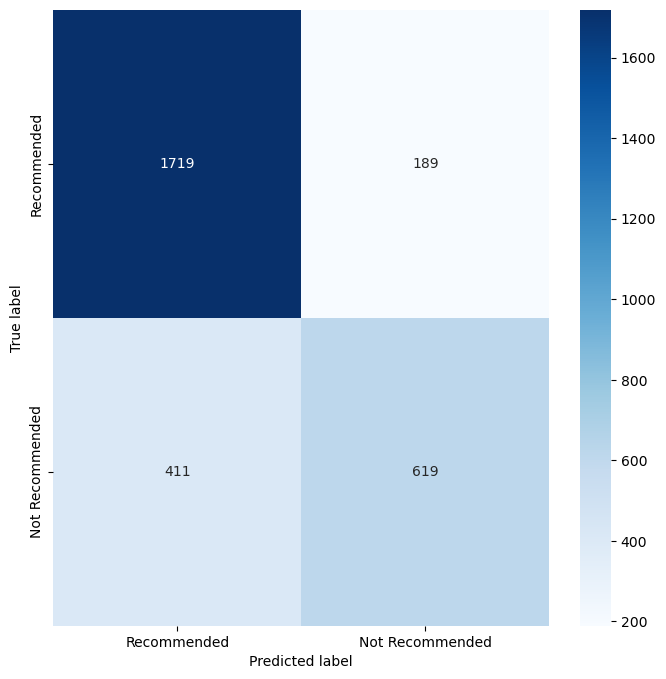

In [22]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

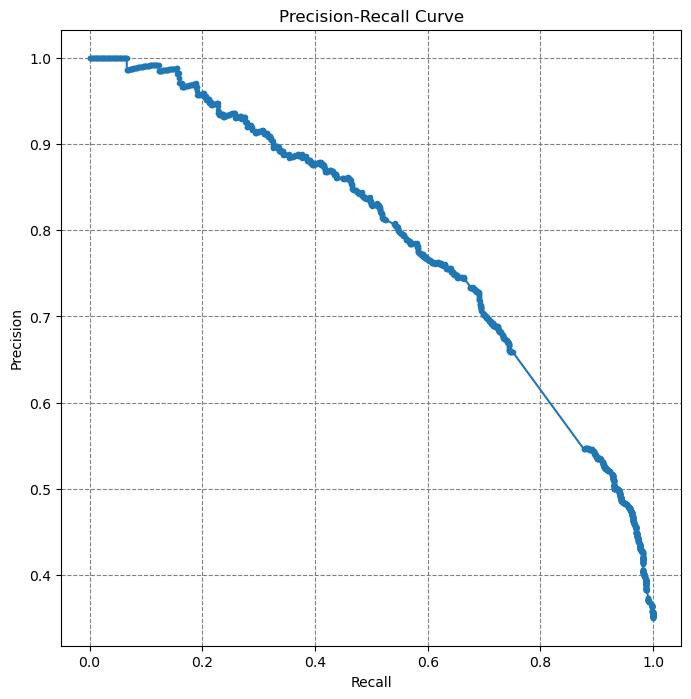

In [23]:
y_probas = model.predict_proba(X_test)[:, 1]
precision_curve, recall_curve, thresholds_curve = precision_recall_curve(y_test, y_probas)

plot_precision_recall_curve(precision_curve, recall_curve)

In [24]:
model.best_estimator_.get_params()

{'memory': None,
 'steps': [('vectorizer',
   TfidfVectorizer(max_features=12000, token_pattern=None,
                   tokenizer=<function tokenize at 0x7f3440899800>)),
  ('model',
   XGBClassifier(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=None, device=None, early_stopping_rounds=None,
                 enable_categorical=False, eta=np.float64(0.2), eval_metric=None,
                 feature_types=None, gamma=None, grow_policy=None,
                 importance_type=None, interaction_constraints=None,
                 learning_rate=None, max_bin=None, max_cat_threshold=None,
                 max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
                 max_leaves=None, min_child_weight=None, missing=nan,
                 monotone_constraints=None, multi_strategy=None, n_estimators=200,
                 n_jobs=None, num_parallel_tree=None, ...))],
 'verbose': False,
 'vec

In [25]:
fpr, tpr, thresholds = roc_curve(y_test, y_probas)

roc_auc = roc_auc_score(y_test, y_probas)

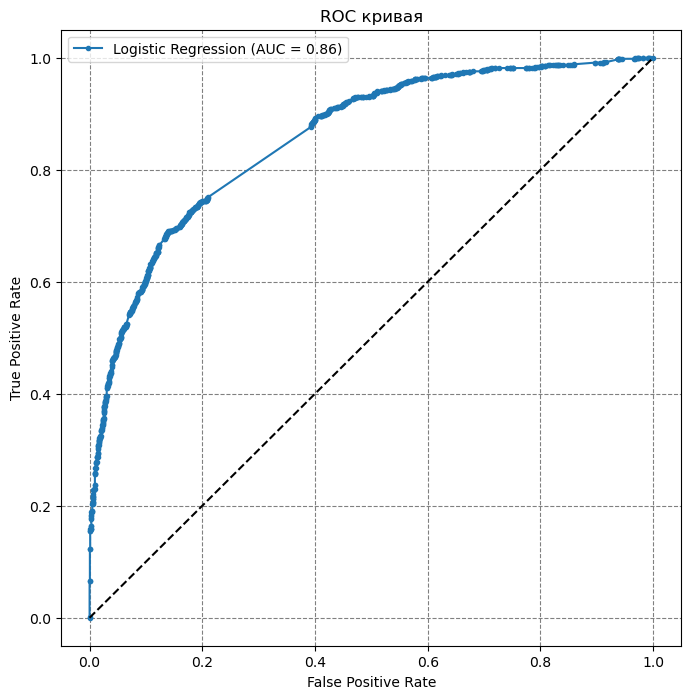

In [26]:
plt.figure(figsize=(8, 8))

plt.plot(fpr, tpr, marker='.', label=f'Logistic Regression (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='black')

plt.grid(True, color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривая')
plt.legend()
plt.show()

In [27]:
threshold = thresholds_curve[np.where(recall_curve > .95)[0][-1]] # Оптимум

In [28]:
precision_recall_score(y_test, y_probas > threshold);

Precision: 0.48320158102766797 
Recall: 0.9495145631067962


Результаты схожи с результатами алгоритма логистической регресии, но немного хуже. В данном случае предпочтение лучше отдать логистической регрессии.